In [1]:
import sys, os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tbparse import SummaryReader
from torch_ac.utils import DictList

/Users/inigo/.local/share/virtualenvs/tfm-experiments-K5nk3NK1/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [100]:
def sorted_listdir(path):
    files = sorted((f for f in os.listdir(path) if not f.startswith(".")), key=str.lower)
    return files

def make_plots(ax, data, approach, color, start=0, title=None):
    label = 'ppo baseline' if approach == 'fine-tuning' else 'ppo + ' + approach
    x = data['step'][start:]
    median = data['mean_reward'][start:]
    # moving average over a window
    #median = median_raw.rolling(window=5).mean()
    std = data['std'][start:]
    ax.plot(x, median, color=color, label=label, lw=1)
    ax.fill_between(x, median - std, median + std, color=color, alpha=0.1, lw=0)
    #ax.legend(loc="lower left")
    if title is not None:
        leg = ax.legend(title=title, loc="lower left", title_fontsize=12)
        ax.get_legend()._legend_box.align = "left"
    else:
        ax.legend(loc="lower left")

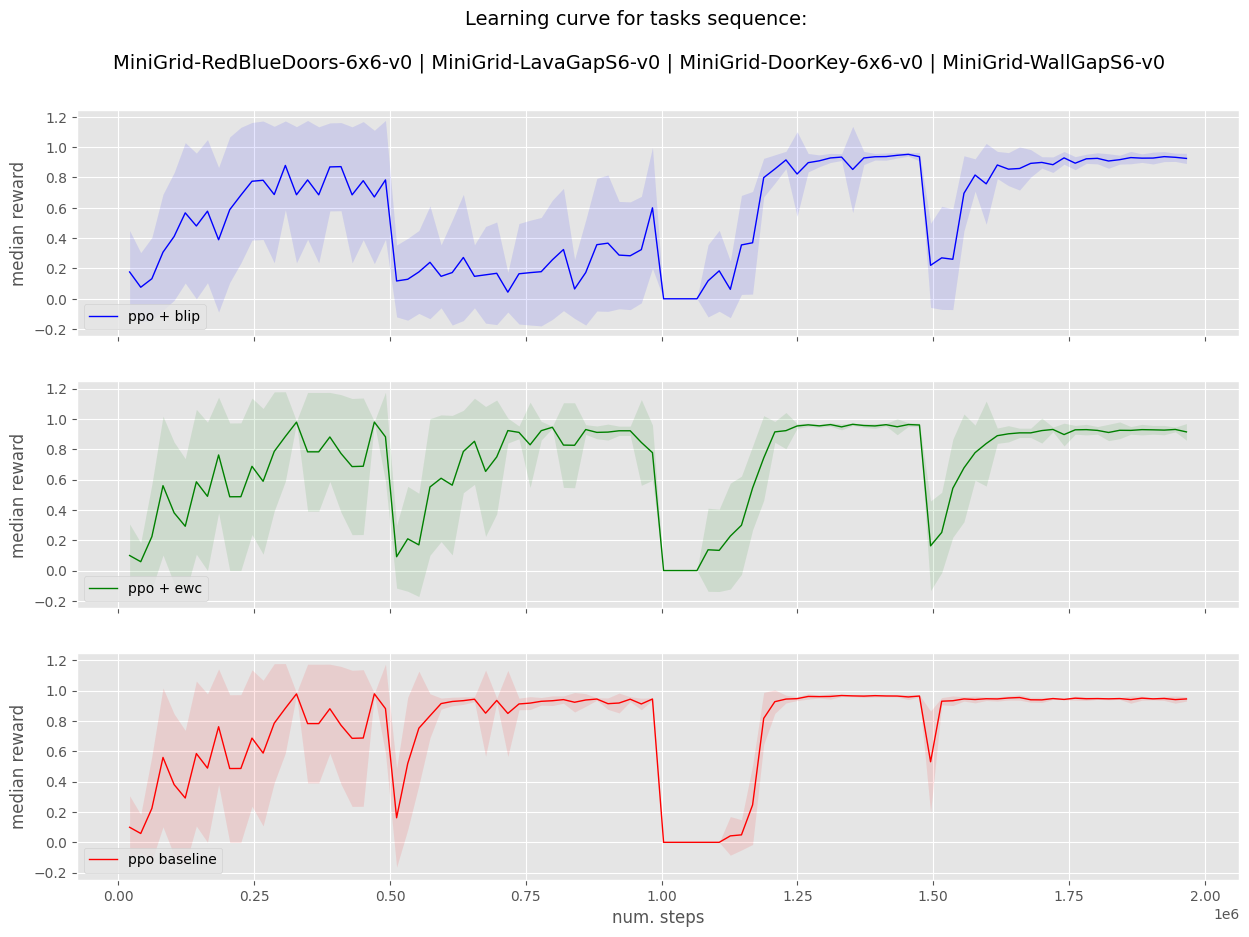

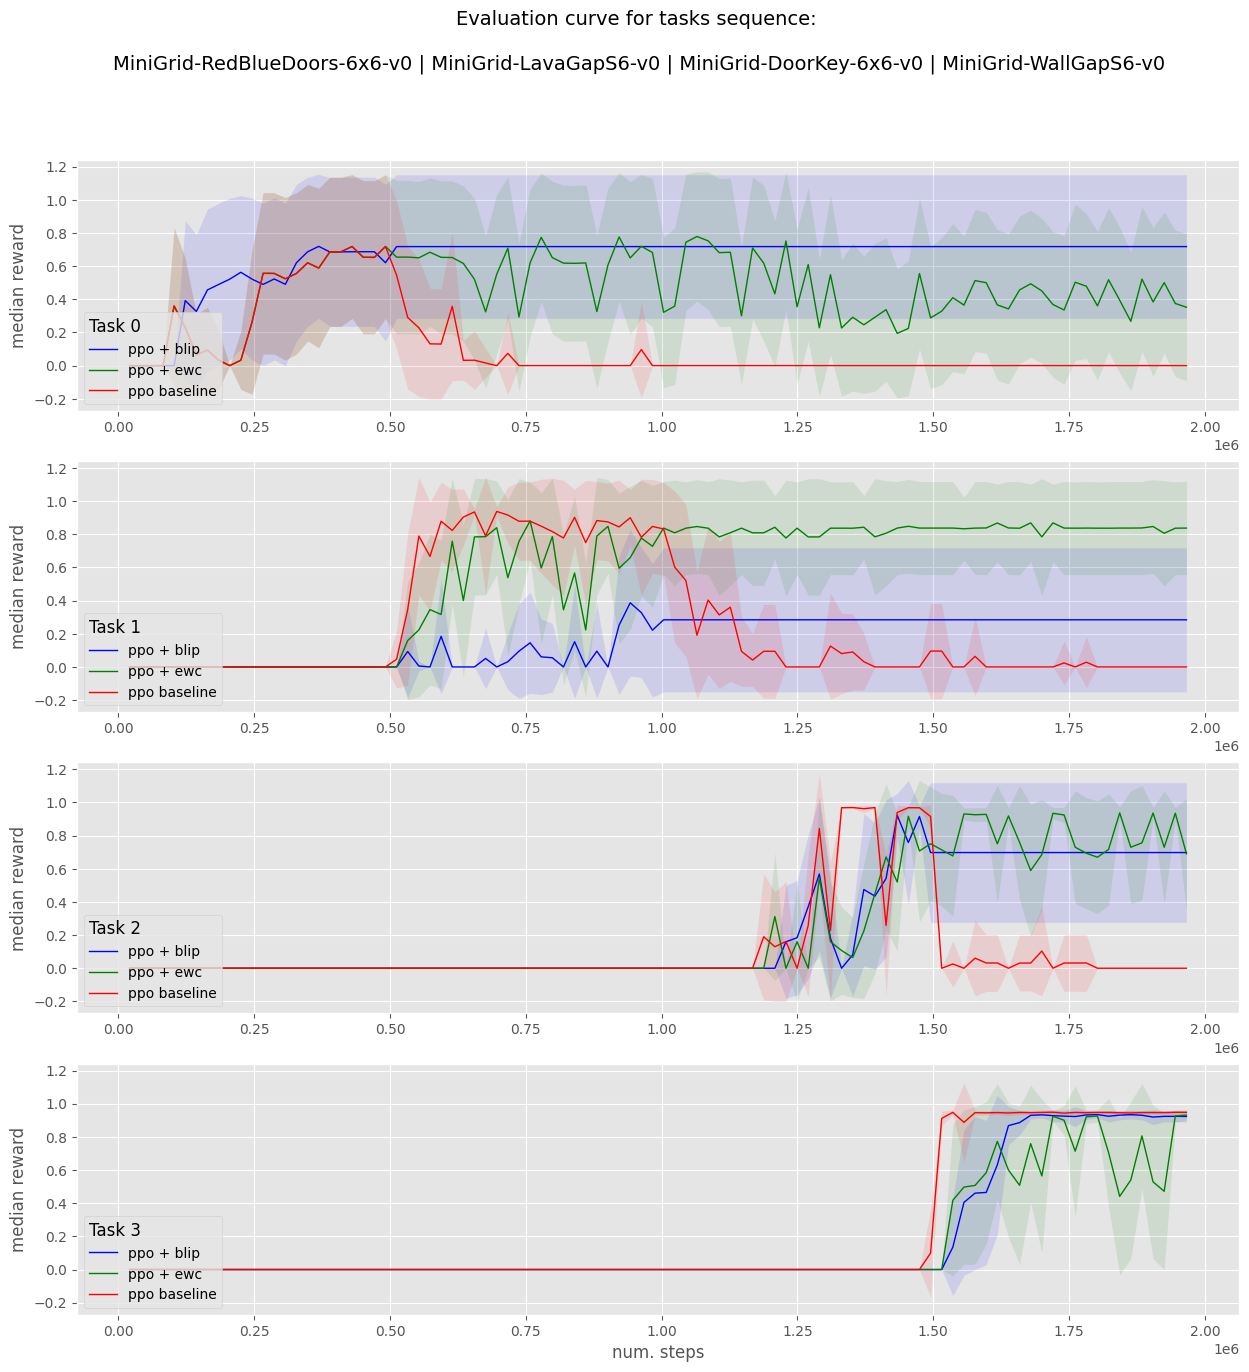

In [116]:
# Experiment details
experiments = [
    ('2023-01-19','doorkey-wallgap-lavagap-redbluedoor', [
    (0, 'MiniGrid-DoorKey-6x6-v0'), 
    (1, 'MiniGrid-WallGapS6-v0'), 
    (2, 'MiniGrid-LavaGapS6-v0'),
    (3, 'MiniGrid-RedBlueDoors-6x6-v0')       
    ]), 
    ('2023-01-21','redbluedoor-lavagap-doorkey-wallgap', [
    (0, 'MiniGrid-RedBlueDoors-6x6-v0'), 
    (1, 'MiniGrid-LavaGapS6-v0'), 
    (2, 'MiniGrid-DoorKey-6x6-v0'), 
    (3, 'MiniGrid-WallGapS6-v0')
    ]), 
    ('2023-01-21','doorkey-wallgap-lavagap-redbluedoor-emptyrand', [
    (0, 'MiniGrid-DoorKey-6x6-v0'), 
    (1, 'MiniGrid-WallGapS6-v0'), 
    (2, 'MiniGrid-LavaGapS6-v0'),
    (3, 'MiniGrid-RedBlueDoors-6x6-v0'),
    (4, 'MiniGrid-Empty-Random-6x6-v0')        
    ]), 
    ('2023-01-22','lavagap-doorkey-emptyrand-redbluedoor-wallgap', [
    (0, 'MiniGrid-LavaGapS6-v0'),
    (1, 'MiniGrid-DoorKey-6x6-v0'), 
    (2, 'MiniGrid-Empty-Random-6x6-v0'), 
    (3, 'MiniGrid-RedBlueDoors-6x6-v0'),
    (4, 'MiniGrid-WallGapS6-v0')
    ])]
    
date = experiments[1][0]
experiment = experiments[1][1]
tasks_sequence = experiments[1][2]
header = 'minigrid'
steps = '5e5'
approaches = ['blip','ewc','fine-tuning']
stages = ['train', 'eval']
seeds = [1,2,3]
F_prior = 5e-18
ewc_lambda = 5000.0

results_dict = {}  
df_list = []

# # 4 Tasks sequence 1
# tasks_sequence = [
#     (0, 'MiniGrid-DoorKey-6x6-v0'), 
#     (1, 'MiniGrid-WallGapS6-v0'), 
#     (2, 'MiniGrid-LavaGapS6-v0'),
#     (3, 'MiniGrid-RedBlueDoors-6x6-v0')       
#     ]

# # 4 Tasks sequence 2
# tasks_sequence = [
#     (0, 'MiniGrid-RedBlueDoors-6x6-v0'), 
#     (1, 'MiniGrid-LavaGapS6-v0'), 
#     (2, 'MiniGrid-DoorKey-6x6-v0'), 
#     (3, 'MiniGrid-WallGapS6-v0')
#     ]

# # 5 Tasks sequence 1
# tasks_sequence = [
#     (0, 'MiniGrid-DoorKey-6x6-v0'), 
#     (1, 'MiniGrid-WallGapS6-v0'), 
#     (2, 'MiniGrid-LavaGapS6-v0'),
#     (3, 'MiniGrid-RedBlueDoors-6x6-v0'),
#     (4, 'MiniGrid-Empty-Random-6x6-v0')        
#     ]

# # 5 Tasks sequence 2
# tasks_sequence = [
#     (0, 'MiniGrid-LavaGapS6-v0'),
#     (1, 'MiniGrid-DoorKey-6x6-v0'), 
#     (2, 'MiniGrid-Empty-Random-6x6-v0'), 
#     (3, 'MiniGrid-RedBlueDoors-6x6-v0'),
#     (4, 'MiniGrid-WallGapS6-v0')
#     ]

last_task_idx = tasks_sequence[-1][0]
results_dict['num_tasks'] = len(tasks_sequence)

sequence = ''
for task in tasks_sequence:
    if task[0] == len(tasks_sequence) - 1:
        sequence = sequence + task[1]
    else:
        sequence = sequence + task[1] + ' | '
results_dict['sequence'] = sequence
task_updates = 96 / len(tasks_sequence)

# Main plot settings
plt.style.use('ggplot')
#color = iter(plt.cm.Set2(np.linspace(0, 1, len(approaches))))
color = iter(['b','g','r'])
fig_train, axs_train = plt.subplots(len(approaches), sharey=True, figsize=(15, 10))
fig_eval, axs_eval = plt.subplots(len(tasks_sequence), sharey=True, figsize=(15, 15))
#fig_eval, axs_eval = plt.subplots(2,2, sharey=True, figsize=(15, 15))

# Main plotting loop
for n, approach in enumerate(approaches):
    results_dict['approach'] = {approach:{}}
    # a diff. color for each approach
    c = next(color)
    results_dict['approach'][approach]['color'] = c
    for i, seed in enumerate(seeds):
        if approach == 'fine-tuning' or approach == 'ft-fix':
            log_name = '{}_{}_{}_{}_{}_{}'.format(date, header, steps, experiment, approach, seed)
        elif approach == 'ewc' in approach:
            log_name = '{}_{}_{}_{}_{}_{}_lamb_{}'.format(date, header, steps, experiment, approach, seed, ewc_lambda)
        elif approach == 'blip':
            log_name = '{}_{}_{}_{}_{}_{}_F_prior_{}'.format(date, header, steps, experiment, approach, seed, F_prior)
        for stage in stages:
            if stage == 'train':   
                if i == 0:
                    results_dict['approach'][approach][stage] = {}
                    results_dict['approach'][approach][stage]['data'] = []

                train_dir = os.path.join("./result_data/", log_name, "train")
                event_file = os.path.join(train_dir, sorted_listdir(train_dir)[0])
                reader = SummaryReader(event_file, pivot=True)
                df = reader.scalars
                df_mean_std = df[['step', 'mean_reward', 'std']]
                results_dict['approach'][approach][stage]['data'].append(df_mean_std)
                # Check if last seed data has been reached and process the data
                if seed == seeds[-1]:
                    df_list = results_dict['approach'][approach][stage]['data']
                    df_all = pd.concat(df_list)
                    df_all_median = pd.concat(df_list).groupby(['step'])['mean_reward'].median().reset_index()
                    df_merged = df_all_median.merge(df_all[['mean_reward','std']].drop_duplicates('mean_reward'), how='left', on='mean_reward')
                    results_dict['approach'][approach][stage]['merged'] = df_merged
                    fig_train.suptitle('Learning curve for tasks sequence: '+'\n\n'+results_dict['sequence'], fontsize=14)
                    ax = axs_train[n]
                    start = 0
                    make_plots(ax, df_merged, approach, c, start)

            elif stage == 'eval':
                if i == 0: results_dict['approach'][approach][stage] = {}
                for task in tasks_sequence:
                    if i == 0:
                        results_dict['approach'][approach][stage]["task_"+str(task[0])] = {}
                        results_dict['approach'][approach][stage]["task_"+str(task[0])]['name'] = task[1]
                        results_dict['approach'][approach][stage]["task_"+str(task[0])]['data'] = []

                    eval_dir = os.path.join("./result_data/", log_name, "eval", "task_"+str(task[0]))
                    event_file = os.path.join(eval_dir, sorted_listdir(eval_dir)[0])
                    reader = SummaryReader(event_file, pivot=True)
                    df = reader.scalars
                    df_mean_std = df[['step', 'mean_reward', 'std']]
                    results_dict['approach'][approach][stage]["task_"+str(task[0])]['data'].append(df_mean_std)
                    # Check if last seed data has been reached and process the data
                    if seed == seeds[-1]:
                        df_list = results_dict['approach'][approach][stage]["task_"+str(task[0])]['data']
                        df_all = pd.concat(df_list)
                        df_all_median = pd.concat(df_list).groupby(['step'])['mean_reward'].median().reset_index()
                        df_merged = df_all_median.merge(df_all[['mean_reward','std']].drop_duplicates('mean_reward'), how='left', on='mean_reward')
                        results_dict['approach'][approach][stage]["task_"+str(task[0])]['merged'] = df_merged
                        fig_eval.suptitle('Evaluation curve for tasks sequence: '+'\n\n'+results_dict['sequence'], fontsize=14)                   
                        # a="{0:b}".format(task[0])
                        # if len(a) == 1:
                        #     ax = axs_eval[0, int(a[0])]
                        # else:
                        #     ax = axs_eval[int(a[0]), int(a[1])]
                        ax = axs_eval[task[0]]
                        #start = int(task[0] * task_updates)
                        start = 0
                        title = 'Task '+str(task[0])
                        make_plots(ax, df_merged, approach, c, start, title)

for ax in axs_train.flat:
    ax.set(xlabel='num. steps', ylabel='median reward')
    ax.label_outer()

for i, ax in enumerate(axs_eval.flat):
    ax.set(ylabel='median reward')
    if i == len(tasks_sequence)-1 :
        ax.set(xlabel='num. steps')
